# Demo of spectral extractions and analysis as of May 2024

Note this is a copy of Gabe Brammer's msaexp example notebook: https://github.com/gbrammer/msaexp/tree/main/docs/examples

We will use this notebook to do some high level work on reduced data such as fitting redshifts and obtaining line fluxes etc. 


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import yaml

import astropy.units as u
import astropy.io.fits as pyfits

import mastquery.utils
from grizli import utils
import msaexp.slit_combine
import msaexp.spectrum
import msaexp

print('msaexp version: ', msaexp.__version__)

Matplotlib is building the font cache; this may take a moment.


Failed to `import dust_attenuation`
Install from the repo with $ pip install git+https://github.com/karllark/dust_attenuation.git
msaexp version:  0.8.5


## A reduced RUBIES spectrum

https://s3.amazonaws.com/msaexp-nirspec/extractions/rubies-egs61-v2/index.html

In [19]:
## this can also be a physical spec.fits file made from the 4_1 notebook. 
spec_file = 'rubies-egs61-v2_prism-clear_4233_44597.spec.fits'

srcid = spec_file.split('_')[-1].split('.spec.fits')[0]
spec_root = spec_file.split('_')[0]
spec_url = f'https://s3.amazonaws.com/msaexp-nirspec/extractions/{spec_root}/{spec_file}'

spec_hdu = pyfits.open(spec_url) ### or use spec_file directly to use fil from directory
spec_hdu.writeto(spec_file, overwrite=True)

spec_hdu.info()

Filename: /Users/wnanayakkara/.astropy/cache/download/url/5c8f951b6b3800343d126ea3fc2fe64b/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU    303   435R x 4C   [D, D, D, D]   
  2  SCI           1 ImageHDU       290   (435, 31)   float64   
  3  WHT           1 ImageHDU       290   (435, 31)   float64   
  4  PROFILE       1 ImageHDU       290   (435, 31)   float64   
  5  PROF1D        1 BinTableHDU     25   31R x 3C   [D, D, D]   


In [3]:
spec = utils.read_catalog(spec_file)
spec.info()

<GTable length=435>
   name    dtype  unit  format     class     n_bad
--------- ------- ---- -------- ------------ -----
     wave float64   um                Column     0
     flux float64  uJy          MaskedColumn    16
      err float64  uJy                Column    12
path_corr float64      {:11.2f}       Column     0


In [4]:
# Lots of metadata
print(yaml.dump(dict(spec.meta)))

ACT_ID: '01'
APERNAME: NRS_FULL_MSA
APER_DY: 1
APER_Y0: 15
BARTDELT: 317.449378
BENDTIME: 60382.406797
BKGDTARG: false
BMIDTIME: 60382.401225
BSTRTIME: 60382.395653
BUNIT: microJansky
CAL_VCS: RELEASE
CAL_VER: 1.12.5
CATEGORY: GO
COMPRESS: false
CRDS_CTX: jwst_1183.pmap
CRDS_VER: 11.17.14
CROWDFLD: false
DATAMODE: 58
DATAMODL: SlitModel
DATAPROB: false
DATE: '2024-04-19T09:24:37.759'
DATE-BEG: '2024-03-13T09:24:26.953'
DATE-END: '2024-03-13T09:40:29.820'
DATE-OBS: '2024-03-13'
DEC_REF: 52.940253
DEC_V1: 52.782913
DETECTOR: NRS1
DISPAXIS: 1
DRPFRMS1: 0
DRPFRMS3: 0
DURATION: 962.867000
EFFEXPTM: 948.278000
EFFINTTM: 948.277850
ENGQLPTG: CALCULATED_TRACK_TR_202111
ENG_QUAL: OK
EPH_TIME: 60382.397551
EPH_TYPE: Predicted
EXPCOUNT: 4
EXPEND: 60382.403123
EXPMID: 60382.397551
EXPOSURE: '2'
EXPRIPAR: PRIME
EXPSTART: 60382.391979
EXPTIME: 2844.834000
EXP_ONLY: false
EXP_TYPE: NRS_MSASPEC
EXTNAME: SPEC1D
EXTNCRS: 0.000000
EXTVER: 1
FASTAXIS: 2
FILENAME: jw04233006001_03101_00002_nrs1_phot.186.42

### Shutter footprints

See if you can match the image you receive here with the APT using ALADIN

(-0.5, 239.5, 239.5, -0.5)

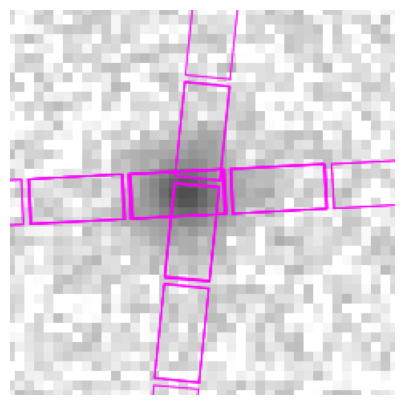

In [5]:
import PIL
import urllib

# Cutout figure
cutout_url = "https://grizli-cutout.herokuapp.com/thumb?size=1&scl=4.0&invert=True&filters=f444w-clear&rgb_scl=1.5%2C0.74%2C1.3&pl=2&coord={SRCRA},{SRCDEC}&nirspec=True&dpi_scale=6&nrs_source=magenta&nrs_other=magenta&nrs_lw=0.5&nrs_alpha=0.8"

img = np.array(PIL.Image.open(urllib.request.urlopen(cutout_url.format(**spec.meta))))

fig, ax = plt.subplots(1,1,figsize=(5,5))
_ = ax.imshow(img[::-1,:,:])
ax.axis('off')

In [6]:
# The actual footprints
slits_url = "https://grizli-cutout.herokuapp.com/nirspec_slits?coord={SRCRA},{SRCDEC}"
slits = utils.read_catalog(slits_url.format(**spec.meta), format='csv')
slits['program','source_id','grating','is_source','footprint']

program,source_id,grating,is_source,footprint
int64,int64,str5,str5,str93
1345,12308,G140M,False,"((214.974736,52.924636),(214.974737,52.924571),(214.974513,52.924569),(214.974511,52.924634))"
1345,12308,G140M,True,"((214.974495,52.924634),(214.974497,52.924569),(214.974272,52.924567),(214.974271,52.924632))"
1345,12308,G140M,False,"((214.974255,52.924632),(214.974256,52.924567),(214.974032,52.924565),(214.974030,52.924630))"
1345,12308,G140M,True,"((214.974492,52.924634),(214.974494,52.924570),(214.974269,52.924568),(214.974268,52.924632))"
1345,12308,G140M,False,"((214.974252,52.924632),(214.974253,52.924568),(214.974028,52.924566),(214.974027,52.924630))"
1345,12308,G140M,False,"((214.974011,52.924630),(214.974013,52.924566),(214.973788,52.924564),(214.973787,52.924628))"
1345,12308,G140M,False,"((214.974980,52.924637),(214.974981,52.924573),(214.974756,52.924571),(214.974755,52.924636))"
1345,12308,G140M,False,"((214.974739,52.924635),(214.974740,52.924571),(214.974516,52.924569),(214.974515,52.924634))"
1345,12308,G140M,True,"((214.974499,52.924633),(214.974500,52.924569),(214.974275,52.924567),(214.974274,52.924632))"


### Read the MAST spectrum for comparison

In [20]:
mast_file = 'jw{PROGRAM}-o{OBSERVTN}_s{SOURCEID}_nirspec_{FILTER}-{GRATING}_x1d.fits'.format(**spec.meta).lower()
mast_url = 'https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:JWST/product/' + mast_file

mast = utils.read_catalog(mast_url)

In [21]:
mast.info()

<GTable length=431>
      name        dtype     unit       class     n_bad
---------------- ------- ---------- ------------ -----
      WAVELENGTH float64         um       Column     0
            FLUX float64         Jy       Column     0
      FLUX_ERROR float64         Jy MaskedColumn    24
FLUX_VAR_POISSON float64        Jy2 MaskedColumn    24
 FLUX_VAR_RNOISE float64        Jy2 MaskedColumn    23
   FLUX_VAR_FLAT float64        Jy2 MaskedColumn    23
     SURF_BRIGHT float64   MJy / sr       Column     0
        SB_ERROR float64   MJy / sr       Column     0
  SB_VAR_POISSON float64 MJy2 / sr2       Column     0
   SB_VAR_RNOISE float64 MJy2 / sr2       Column     0
     SB_VAR_FLAT float64 MJy2 / sr2       Column     0
              DQ  uint32                  Column     0
      BACKGROUND float64   MJy / sr       Column     0
      BKGD_ERROR float64   MJy / sr       Column     0
BKGD_VAR_POISSON float64 MJy2 / sr2       Column     0
 BKGD_VAR_RNOISE float64 MJy2 / sr2       Col

# Plot the spectrum

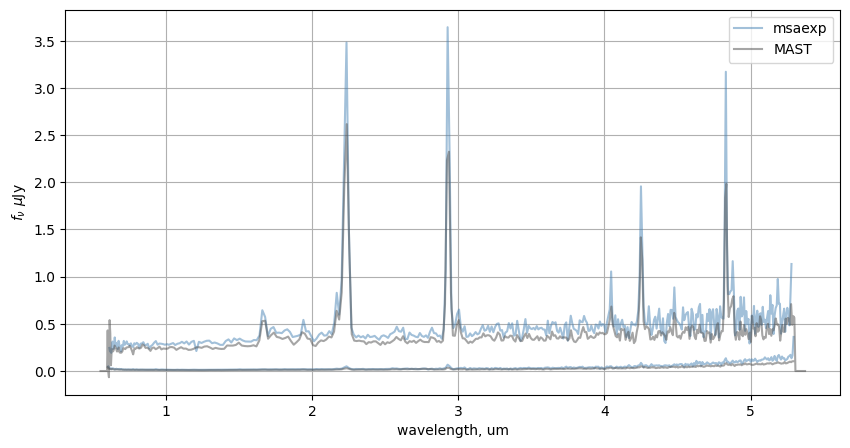

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

pl = ax.plot(spec['wave'], spec['flux'], label='msaexp', color='steelblue', alpha=0.5)
ax.plot(spec['wave'], spec['err'], color=pl[0].get_color(), alpha=0.5)

pl = ax.plot(mast['WAVELENGTH'], mast['FLUX'].to('microJansky'), label='MAST', color='0.3', alpha=0.5)
ax.plot(mast['WAVELENGTH'], mast['FLUX_ERROR'].to('microJansky'), color=pl[0].get_color(), alpha=0.5)

ax.legend()

ax.set_xlabel('wavelength, um')
ax.set_ylabel(r'$f_\nu$ $\mu$Jy')
ax.grid()

# Fitting templates to MSAEXP spectra

# (2024-06-28 03:59:31.436)

spectrum.fit_redshift(**{'file': 'rubies-egs61-v2_prism-clear_4233_44597.spec.fits', 'z0': [1, 6], 'zstep': None, 'nspline': None, 'scale_disp': 1.3, 'vel_width': 100, 'Rline': None, 'is_prism': False, 'use_full_dispersion': False, 'ranges': None, 'sys_err': 0.02, 'kwargs': {'scale_uncertainty_kwargs': {}}, 'froot': 'rubies-egs61-v2_prism-clear_4233_44597'})



627it [00:12, 51.13it/s] 
101it [00:00, 183.16it/s]


calc_uncertainty_scale: Mask additional 1 pixels
calc_uncertainty_scale: sys_err = 0.0200
calc_uncertainty_scale: coeffs = [0.11909925]
calc_uncertainty_scale: NMAD = 0.991
calc_uncertainty_scale: Set SCALE_UNCERTAINTY: [0.11909925]

# line flux err
# flux x 10^-20 erg/s/cm2
# rubies-egs61-v2_prism-clear_4233_44597.spec.fits
# z = 3.46038
# Fri Jun 28 10:59:54 2024
      line OIII-1663      -10.2 ±    174.5 (EW=     -0.7)
      line NIII-1750      -66.6 ±    178.9 (EW=     -4.7)
      line CIII-1906      140.4 ±    159.5 (EW=     12.3)
           line MgII      113.8 ±    117.3 (EW=     20.2)
       line NeV-3346      177.0 ±    109.2 (EW=     42.3)
      line NeVI-3426       26.9 ±    104.6 (EW=      6.7)
            line OII     1383.7 ±    111.1 (EW=    384.7)
       line HeI-3889      475.2 ±     93.9 (EW=    137.5)
     line NeIII-3968      153.0 ±     92.0 (EW=     45.1)
             line Hd      302.3 ±     95.0 (EW=     92.7)
             line Hg      390.1 ±     76.3 (EW=    1

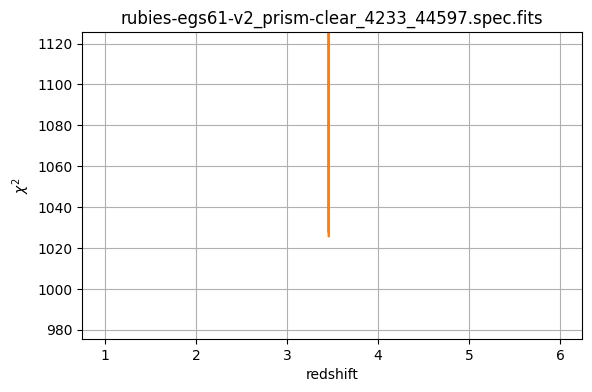

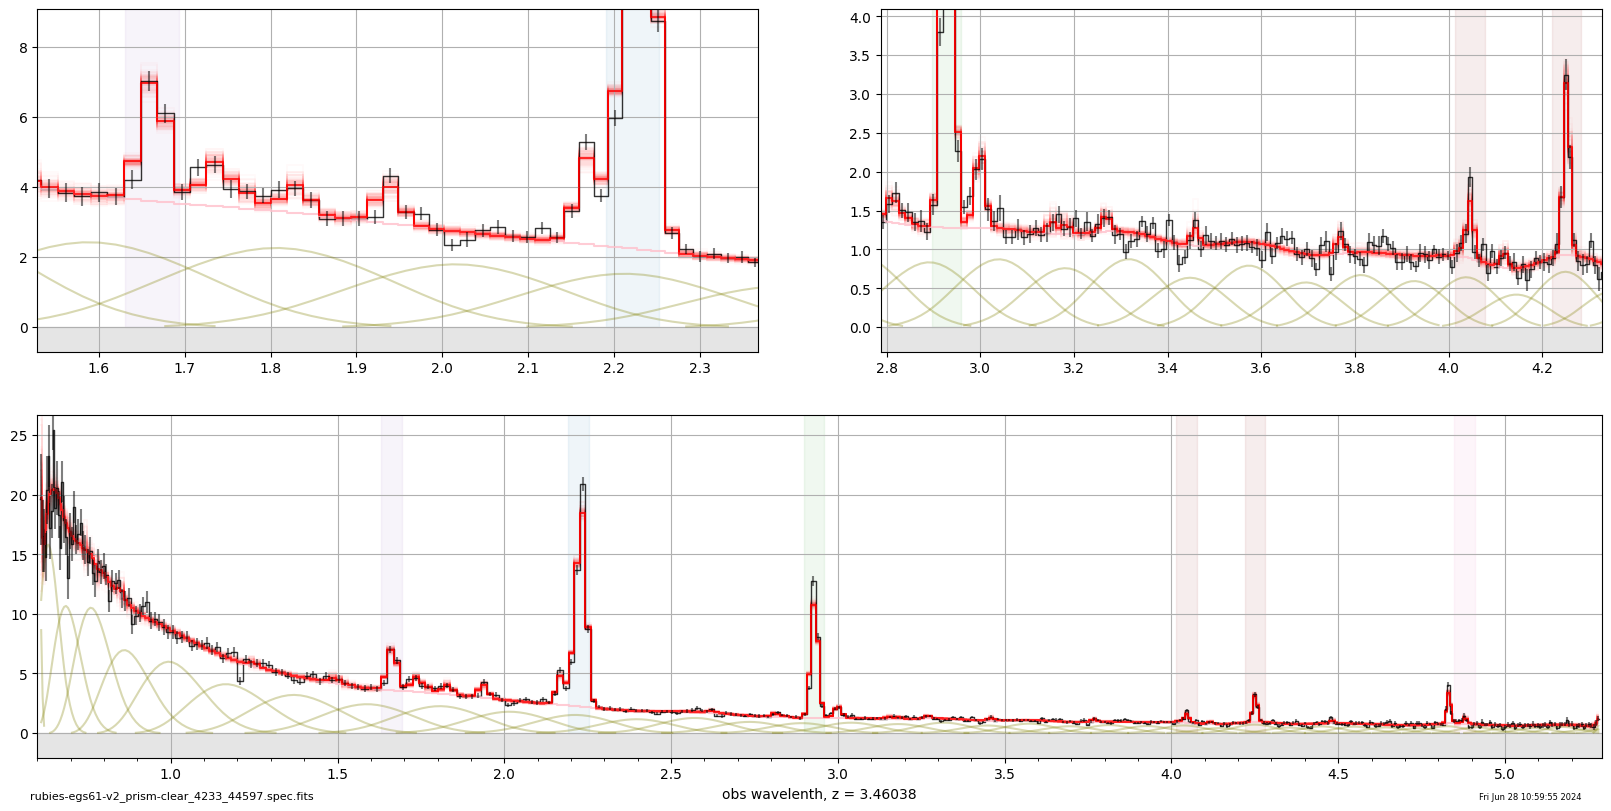

In [10]:
fig, fit_table, fit_result = msaexp.spectrum.fit_redshift(
    spec_file,
    z0=[1,6],
    scale_uncertainty_kwargs={},
)

## Fitting pieces

In [11]:
# Spectrum object - read the spectrum table and add helper methods for fitting
sampler = msaexp.spectrum.SpectrumSampler(spec_file)

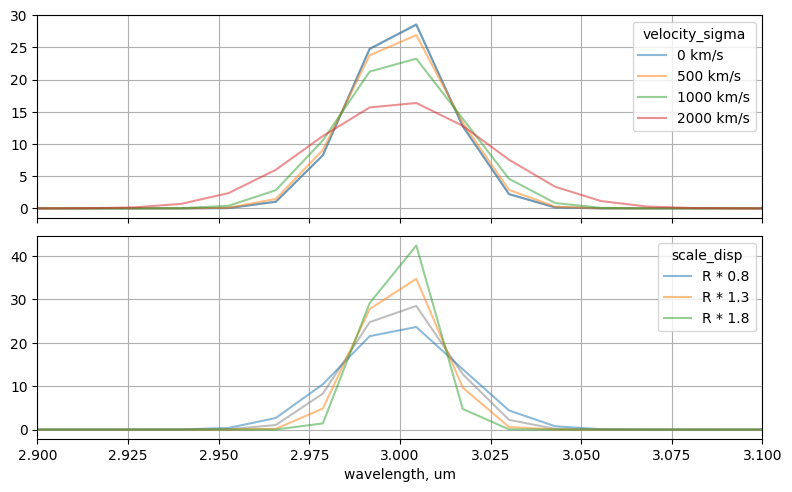

In [12]:
# Generate a single emission line

line_wave = 3.0 # microns

line_i = sampler.fast_emission_line(
    line_wave,
    line_flux=1.0,
    scale_disp=1.0,
    velocity_sigma=100,
)

fig, axes = plt.subplots(2,1,figsize=(8,5), sharex=True)
for ax in axes:
    ax.plot(sampler['wave'], line_i, color='0.5', alpha=0.5)

# Vary line velocity
ax = axes[0]
for velocity_sigma in [0, 500, 1000, 2000]:
    line_i = sampler.fast_emission_line(
        line_wave,
        line_flux=1.0,
        scale_disp=1.0,
        velocity_sigma=velocity_sigma,
    )
    axes[0].plot(sampler['wave'], line_i, label=f'{velocity_sigma} km/s', alpha=0.5)

leg = ax.legend()
leg.set_title('velocity_sigma')

# Vary scale_disp
ax = axes[1]
for scale_disp in [0.8, 1.3, 1.8]:
    line_i = sampler.fast_emission_line(
        line_wave,
        line_flux=1.0,
        scale_disp=scale_disp,
        velocity_sigma=100,
    )
    axes[1].plot(sampler['wave'], line_i, label=f'R * {scale_disp:.1f}', alpha=0.5)

leg = ax.legend()
leg.set_title('scale_disp')

for ax in axes:
    ax.grid()
    ax.set_xlim(line_wave - 0.1, line_wave + 0.1)

ax.set_xlabel('wavelength, um')
fig.tight_layout(pad=1)


In [13]:
# Spline functions for continuum
nspline = 21
bsplines = sampler.bspline_array(nspline=nspline, get_matrix=True)

In [14]:
# Helper for generating emission lines
z = fit_result['z']
_ = msaexp.spectrum.make_templates(sampler, z, bspl=bsplines)
templ_names, is_em_line, templ_matrix = _

print('\n'.join(templ_names))

spl 0
spl 1
spl 2
spl 3
spl 4
spl 5
spl 6
spl 7
spl 8
spl 9
spl 10
spl 11
spl 12
spl 13
spl 14
spl 15
spl 16
spl 17
spl 18
spl 19
spl 20
line OIII-1663
line NIII-1750
line CIII-1906
line MgII
line NeV-3346
line NeVI-3426
line OII
line HeI-3889
line NeIII-3968
line Hd
line Hg
line Hb
line OIII
line HeI-5877
line OI-6302
line Ha+NII
line SII
line HeI-7065
line ArIII-7138
line OII-7325
line ArIII-7753
line HeI-8446
line Pa10
line SIII-9068
line Pa9
line SIII-9531
line Pa8
line PaD
line HeI-1083
line PaG


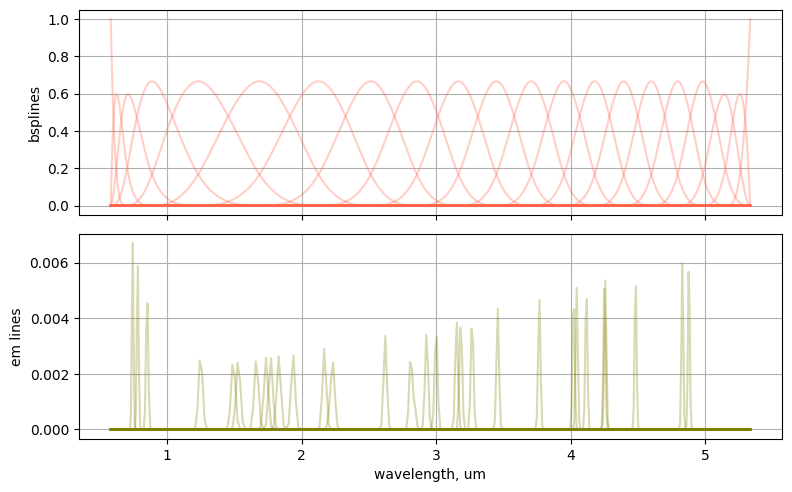

In [15]:
fig, axes = plt.subplots(2,1,figsize=(8,5), sharex=True)
_ = axes[0].plot(sampler['wave'], templ_matrix[~is_em_line].T, alpha=0.3, color='tomato')
axes[0].set_ylabel('bsplines')

_ = axes[1].plot(sampler['wave'], templ_matrix[is_em_line].T, alpha=0.3, color='olive')
axes[1].set_ylabel('em lines')
for ax in axes:
    ax.grid()

ax.set_xlabel('wavelength, um')
fig.tight_layout(pad=1)

### Fit the template matrix to the spectrum with least squares


In [16]:
# Weighted by uncertainties
A = (templ_matrix / sampler['full_err']).T
b = sampler['flux'] / sampler['full_err']

coeffs = np.linalg.lstsq(A[sampler['valid'],:], b[sampler['valid']], rcond=None)

model = templ_matrix.T.dot(coeffs[0])
model_components = templ_matrix.T*coeffs[0]

# Mask for plot
model_components[model_components < 1.e-3] = np.nan

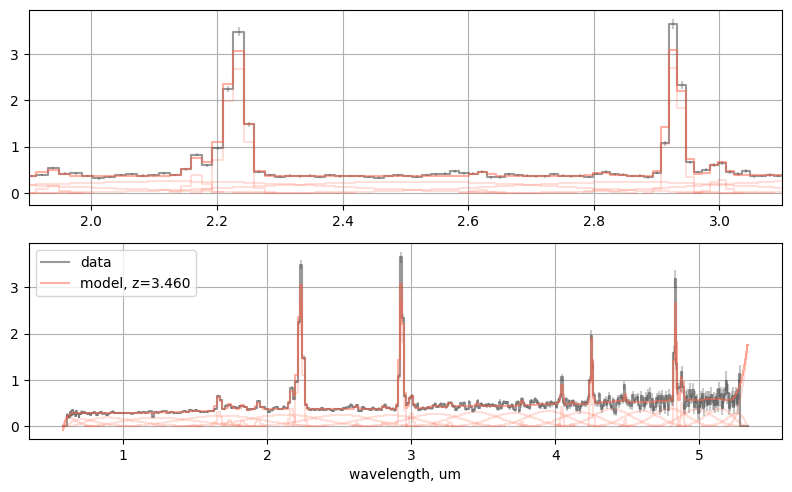

In [17]:
fig, axes = plt.subplots(2,1,figsize=(8,5))

for ax in axes:
    _ = ax.errorbar(sampler['wave'], sampler['flux'], sampler['full_err'],
                    linestyle='None', alpha=0.3, color='0.3', marker='None')
    
    ax.step(sampler['wave'], sampler['flux'], color='0.2', where='mid', alpha=0.5, label='data')
    
    ax.step(sampler['wave'], model, color='tomato', where='mid', alpha=0.5, label=f'model, z={z:.3f}')
    ax.step(sampler['wave'], model_components, color='tomato', where='mid', alpha=0.2)
    
    ax.grid()

axes[0].set_xlim(1.9, 3.1)

ax.legend()
ax.set_xlabel('wavelength, um')
fig.tight_layout(pad=1)
